# Config file of an example using LSTM-KF-RL on a synthetic time series
This file include 
1. synthetic data generation
2. training BDLM-LSTM model with hyper-parameters-free AR
3. check if the BDLM-LSTM model is correct (LSTM, AR, AA)
4. generate time series for RL agent training
5. train RL agents
6. evaluate the performance of RL agents

In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import csv
import pandas as pd
import copy

from tqdm import tqdm
from datetime import datetime, timedelta
from src.RL_functions.generate_synthetic_time_series import *
from examples.data_loader import TimeSeriesDataloader
from pytagi import Normalizer as normalizer
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm
import pytagi.metric as metric
from pytagi import Normalizer

from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.BDLM_trainer import BDLM_trainer
from src.RL_functions.regime_change_detection_RLKF import regime_change_detection_RLKF

## 1. Generate synthetic time series with Kernel regression

In [2]:
components = ['acceleration', 'kernel', 'ar']
hyperparameters = {'acceleration': {'process_error_var': 0.0, 'constant_LA_process_error': 0.0 },
                   'kernel': {'period': 52, 'kernel_length': 0.5, 'sigma_KR0': 0, 'sigma_KR1': 0, 'n_cp':10},
                   'ar': {'phi': 0.9, 'process_error_var': 0.1**2},
                #    'ar': {'phi': 0.75, 'process_error_var': 0**2},
                   'observation': {'error': 1e-20}}
x_init = {
         # 'mu': np.array([0.294, 0.001, 0, 0, -0.35, -0.25, 1.90, 2.81, 1.5, 1.2, 0.7, 0.1, -0.1, -0.15, -0.05]), \
          'mu': np.array([0.294, 0.001, 0, 0, -0.35, -0.25, 1.90, 2.81, -0.03, 0.30, -0.35, 1.70, 0.10, -0.15, -0.05]), \
          'var': np.diag([1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 6.36E-05])}

total_time_steps = int(52*15)
time_step_interval = 7
time_covariates = ['week_of_year']
obs_file_paths = ['data/synthetic_ts/syn_train_obs.csv', 'data/synthetic_ts/syn_val_obs.csv', 'data/synthetic_ts/syn_test_obs.csv']
date_file_paths=['data/synthetic_ts/syn_train_datetime.csv', 'data/synthetic_ts/syn_val_datetime.csv', 'data/synthetic_ts/syn_test_datetime.csv']
np.random.seed(24)

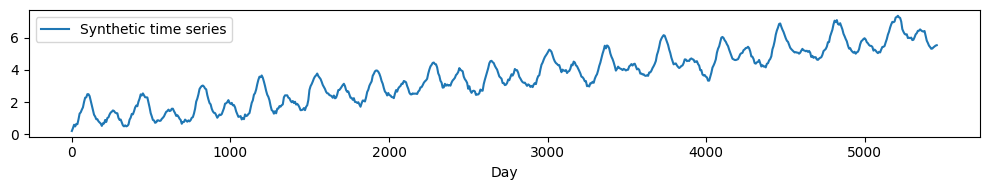

In [3]:
# generate synthetic time series
syn_ts = generate_one_synthetic_time_series(components = components,\
                                      time_step_interval = time_step_interval, \
                                      hyperparameters = hyperparameters,\
                                      num_steps = total_time_steps, \
                                      x_init = x_init,\
                                      # insert_anomaly = True,\
                                      # anomaly_timesteps = [500+hyperparameters['kernel']['period'] * 5],\
                                      # anomaly_LT=[0.003])
                                      insert_anomaly = False)
syn_ts.plot()
syn_ts.export_to_csv(indices_train_val_test=[hyperparameters['kernel']['period'] * 5, hyperparameters['kernel']['period'] * 6, -1],
                     observation_file_paths = obs_file_paths,
                     datetime_file_paths=date_file_paths,
                     start_datetime=datetime(2005, 11, 6, 12, 0, 0))
val_datetime_values = syn_ts.get_validation_datetime_values()

## 2. Train BDLM
The components are AA + AR + LSTM. The AR component here learns automatically the phi_AR and sigma_AR

### BDLM training configuration

In [4]:
num_epochs: int = 50
batch_size: int = 1
sigma_v: float = 1E-12

"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

Epoch 1/50| mse:    0.04:   2%|▏         | 1/50 [00:04<03:53,  4.76s/it]

Current_metric: -1.1494
Optimal_metric: -100000000.0000


Epoch 2/50| mse:    0.04:   4%|▍         | 2/50 [00:09<03:43,  4.66s/it]

Current_metric: -0.8551
Optimal_metric: -1.1494


Epoch 3/50| mse:    0.03:   6%|▌         | 3/50 [00:13<03:34,  4.57s/it]

Current_metric: -1.0508
Optimal_metric: -0.8551


Epoch 4/50| mse:    0.03:   8%|▊         | 4/50 [00:18<03:28,  4.52s/it]

Current_metric:  0.1784
Optimal_metric: -0.8551


Epoch 5/50| mse:    0.03:  10%|█         | 5/50 [00:23<03:30,  4.68s/it]

Current_metric:  0.0726
Optimal_metric:  0.1784


Epoch 6/50| mse:    0.02:  12%|█▏        | 6/50 [00:27<03:23,  4.63s/it]

Current_metric:  0.2108
Optimal_metric:  0.1784


Epoch 7/50| mse:    0.02:  14%|█▍        | 7/50 [00:32<03:20,  4.66s/it]

Current_metric:  0.2103
Optimal_metric:  0.2108


Epoch 8/50| mse:    0.02:  16%|█▌        | 8/50 [00:36<03:12,  4.59s/it]

Current_metric:  0.2393
Optimal_metric:  0.2108


Epoch 9/50| mse:    0.02:  18%|█▊        | 9/50 [00:41<03:05,  4.52s/it]

Current_metric:  0.2518
Optimal_metric:  0.2393


Epoch 10/50| mse:    0.02:  20%|██        | 10/50 [00:45<02:56,  4.41s/it]

Current_metric:  0.2661
Optimal_metric:  0.2518


Epoch 11/50| mse:    0.02:  22%|██▏       | 11/50 [00:49<02:48,  4.31s/it]

Current_metric:  0.2755
Optimal_metric:  0.2661


Epoch 12/50| mse:    0.02:  24%|██▍       | 12/50 [00:54<02:46,  4.39s/it]

Current_metric:  0.2843
Optimal_metric:  0.2755


Epoch 13/50| mse:    0.02:  26%|██▌       | 13/50 [00:58<02:41,  4.35s/it]

Current_metric:  0.2912
Optimal_metric:  0.2843


Epoch 14/50| mse:    0.02:  28%|██▊       | 14/50 [01:02<02:36,  4.35s/it]

Current_metric:  0.2963
Optimal_metric:  0.2912


Epoch 15/50| mse:    0.02:  30%|███       | 15/50 [01:07<02:32,  4.35s/it]

Current_metric:  0.3021
Optimal_metric:  0.2963


Epoch 16/50| mse:    0.02:  32%|███▏      | 16/50 [01:11<02:30,  4.43s/it]

Current_metric:  0.3070
Optimal_metric:  0.3021


Epoch 17/50| mse:    0.02:  34%|███▍      | 17/50 [01:16<02:25,  4.41s/it]

Current_metric:  0.3105
Optimal_metric:  0.3070


Epoch 18/50| mse:    0.02:  36%|███▌      | 18/50 [01:20<02:18,  4.32s/it]

Current_metric:  0.3148
Optimal_metric:  0.3105


Epoch 19/50| mse:    0.02:  38%|███▊      | 19/50 [01:24<02:15,  4.37s/it]

Current_metric:  0.3184
Optimal_metric:  0.3148


Epoch 20/50| mse:    0.02:  40%|████      | 20/50 [01:28<02:10,  4.35s/it]

Current_metric:  0.3223
Optimal_metric:  0.3184


Epoch 21/50| mse:    0.02:  42%|████▏     | 21/50 [01:33<02:06,  4.36s/it]

Current_metric:  0.3268
Optimal_metric:  0.3223


Epoch 22/50| mse:    0.02:  44%|████▍     | 22/50 [01:37<02:04,  4.43s/it]

Current_metric:  0.3330
Optimal_metric:  0.3268


Epoch 23/50| mse:    0.02:  46%|████▌     | 23/50 [01:42<01:59,  4.44s/it]

Current_metric:  0.3382
Optimal_metric:  0.3330


Epoch 24/50| mse:    0.02:  48%|████▊     | 24/50 [01:46<01:54,  4.42s/it]

Current_metric:  0.3417
Optimal_metric:  0.3382


Epoch 25/50| mse:    0.02:  50%|█████     | 25/50 [01:50<01:48,  4.35s/it]

Current_metric:  0.3452
Optimal_metric:  0.3417


Epoch 26/50| mse:    0.02:  52%|█████▏    | 26/50 [01:55<01:45,  4.38s/it]

Current_metric:  0.3473
Optimal_metric:  0.3452


Epoch 27/50| mse:    0.02:  54%|█████▍    | 27/50 [01:59<01:41,  4.42s/it]

Current_metric:  0.3487
Optimal_metric:  0.3473


Epoch 28/50| mse:    0.01:  56%|█████▌    | 28/50 [02:04<01:37,  4.42s/it]

Current_metric:  0.3499
Optimal_metric:  0.3487


Epoch 29/50| mse:    0.01:  58%|█████▊    | 29/50 [02:08<01:33,  4.47s/it]

Current_metric:  0.3490
Optimal_metric:  0.3499


Epoch 30/50| mse:    0.01:  60%|██████    | 30/50 [02:13<01:31,  4.57s/it]

Current_metric:  0.3463
Optimal_metric:  0.3499


Epoch 31/50| mse:    0.01:  62%|██████▏   | 31/50 [02:18<01:25,  4.53s/it]

Current_metric:  0.3449
Optimal_metric:  0.3499


Epoch 32/50| mse:    0.01:  64%|██████▍   | 32/50 [02:22<01:21,  4.51s/it]

Current_metric:  0.3398
Optimal_metric:  0.3499


Epoch 33/50| mse:    0.01:  66%|██████▌   | 33/50 [02:27<01:16,  4.51s/it]

Current_metric:  0.3362
Optimal_metric:  0.3499


Epoch 34/50| mse:    0.01:  68%|██████▊   | 34/50 [02:31<01:12,  4.51s/it]

Current_metric:  0.3308
Optimal_metric:  0.3499


Epoch 35/50| mse:    0.01:  70%|███████   | 35/50 [02:36<01:07,  4.47s/it]

Current_metric:  0.3258
Optimal_metric:  0.3499


Epoch 36/50| mse:    0.01:  72%|███████▏  | 36/50 [02:40<01:02,  4.46s/it]

Current_metric:  0.3216
Optimal_metric:  0.3499


Epoch 37/50| mse:    0.01:  74%|███████▍  | 37/50 [02:44<00:58,  4.48s/it]

Current_metric:  0.3154
Optimal_metric:  0.3499


Epoch 38/50| mse:    0.01:  76%|███████▌  | 38/50 [02:49<00:53,  4.45s/it]

Current_metric:  0.3098
Optimal_metric:  0.3499


Epoch 39/50| mse:    0.01:  76%|███████▌  | 38/50 [02:53<00:54,  4.57s/it]

Current_metric:  0.3042
Optimal_metric:  0.3499
Early stopping at epoch 27


#############
MSE           :  0.14
Log-likelihood: -0.92
0.8730996796795373
0.00920390495324128
0.00126683691017255
2.9499055350690444e-06


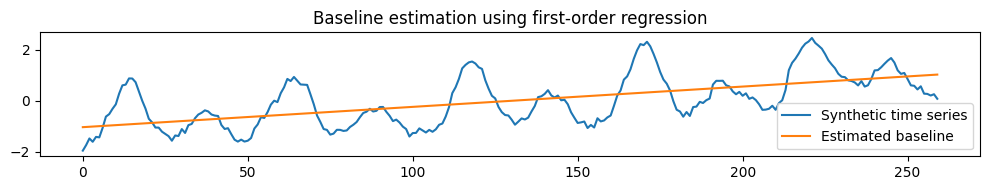

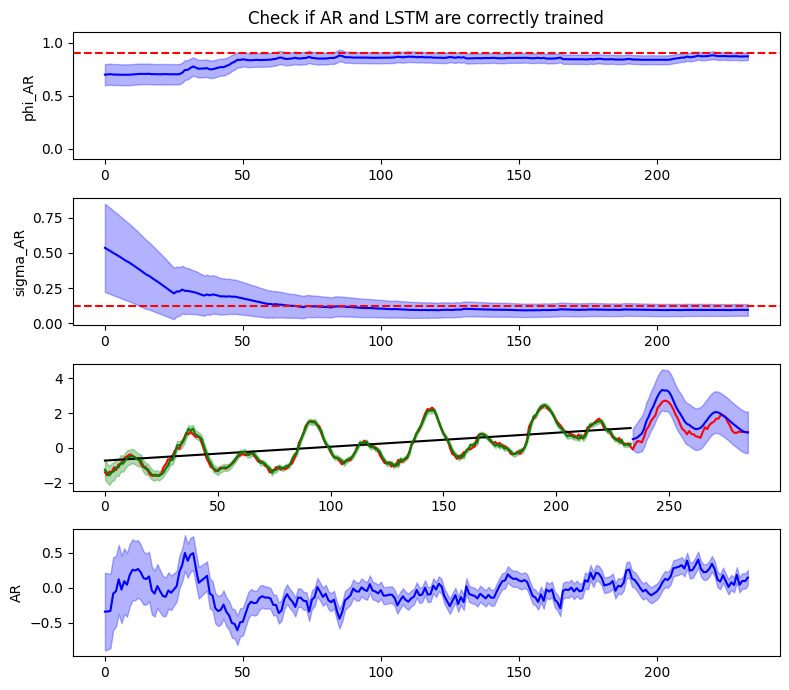

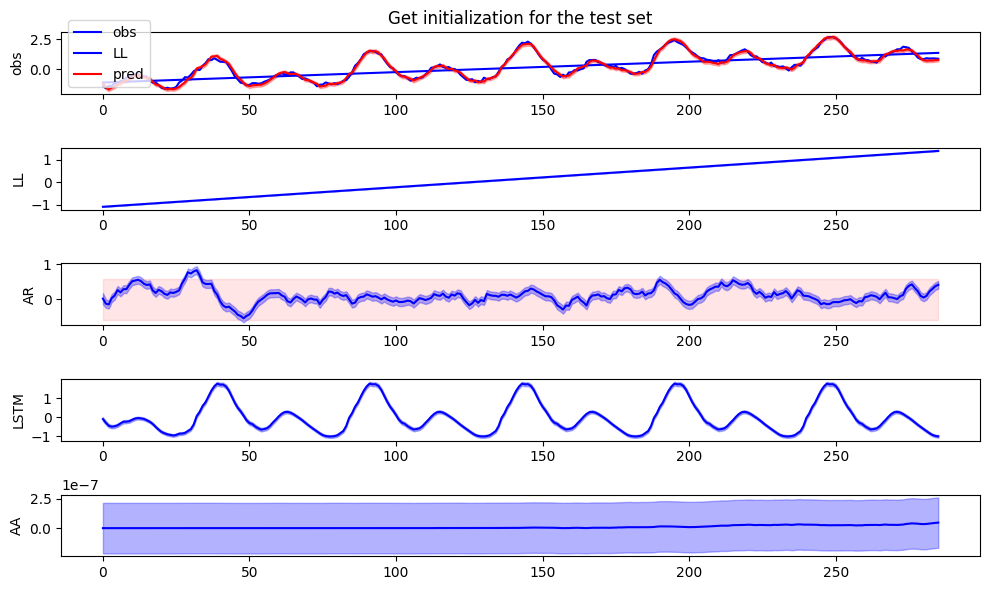

In [5]:
BDLM = BDLM_trainer(num_epochs=num_epochs,
                    batch_size=batch_size,
                    sigma_v=sigma_v,
                    output_col=output_col,
                    num_features=num_features,
                    input_seq_len=input_seq_len,
                    output_seq_len=output_seq_len,
                    seq_stride=seq_stride)
BDLM.load_datasets(obs_file_paths, date_file_paths, time_covariates)
BDLM.estimate_initial_baseline(plot=True)

LA_var_stationary = BDLM.Sigma_AA_ratio*1/(1-BDLM.phi_AA**2)
# BDLM.train(plot=True, true_phiAR = hyperparameters['ar']['phi'], true_SigmaAR = hyperparameters['ar']['process_error_var'],
#            initial_z=np.array([(x_init['mu'][0]+0.6-BDLM.train_dtl.x_mean[0])/ (BDLM.train_dtl.x_std[0] + 1e-10), x_init['mu'][1]*time_step_interval/ (BDLM.train_dtl.x_std[0] + 1e-10), 0, 0.7, 0.02]),
#            initial_Sz=np.array([1E-15, 1E-15, LA_var_stationary, 0.1**2, 0.15**2]))
BDLM.train(plot=True, true_phiAR = hyperparameters['ar']['phi'], true_SigmaAR = hyperparameters['ar']['process_error_var'], early_stopping=True, patience=10)
BDLM.save_LSTM_model(path = './saved_param/syn/lstm_syn.pth')
# Store the smoothed initial value from training + validation sets, and remove the phi_AR hidden state
print(BDLM.phi_AR)
print(BDLM.Sigma_AR)
print(BDLM.var_phi_AR)
print(BDLM.var_Sigma_AR)

# BDLM.phi_AR = 0.9202339226478589
# BDLM.Sigma_AR = 0.007139401587562766
# BDLM.var_phi_AR = 0.0012718482597044068
# BDLM.var_Sigma_AR = 3.128767203684033e-06

BDLM.load_LSTM_model(path = './saved_param/syn/lstm_syn.pth')

LA_var_stationary = BDLM.Sigma_AA_ratio*BDLM.Sigma_AR/(1-BDLM.phi_AA**2)
LSTM_net, init_mu_lstm, init_var_lstm, init_z, init_Sz, init_mu_W2b, init_var_W2b,\
last_seq_obs, last_seq_datetime, last_lstm_x = BDLM.get_testing_model_initials(val_datetime_values=val_datetime_values, plot=True,
           initial_z=np.array([(x_init['mu'][0]+0.6-BDLM.train_dtl.x_mean[0])/ (BDLM.train_dtl.x_std[0] + 1e-10), x_init['mu'][1]*time_step_interval/ (BDLM.train_dtl.x_std[0] + 1e-10), 0, 0.02]),
           initial_Sz=np.array([1E-15, 1E-15, LA_var_stationary, 0.15**2]))
init_z[2]=0

## 3. Check if AA is correct

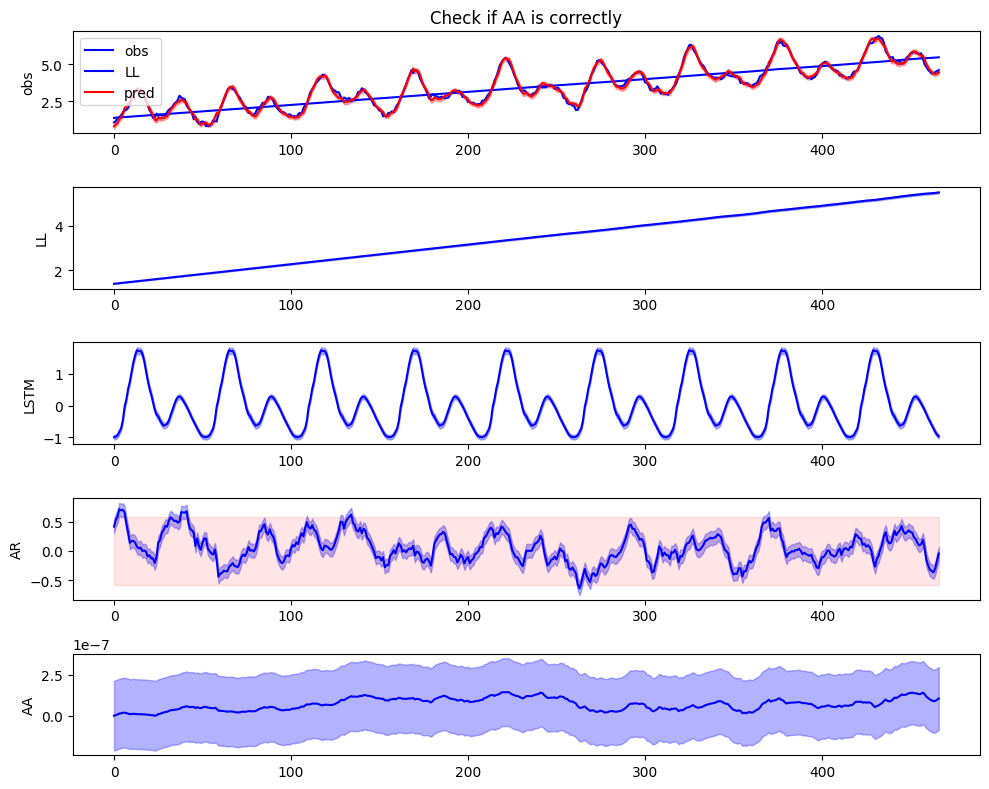

In [6]:
BDLM.check_AA(plot = True)

## 4. RL agent

100%|██████████| 200/200 [09:47<00:00,  2.94s/it]


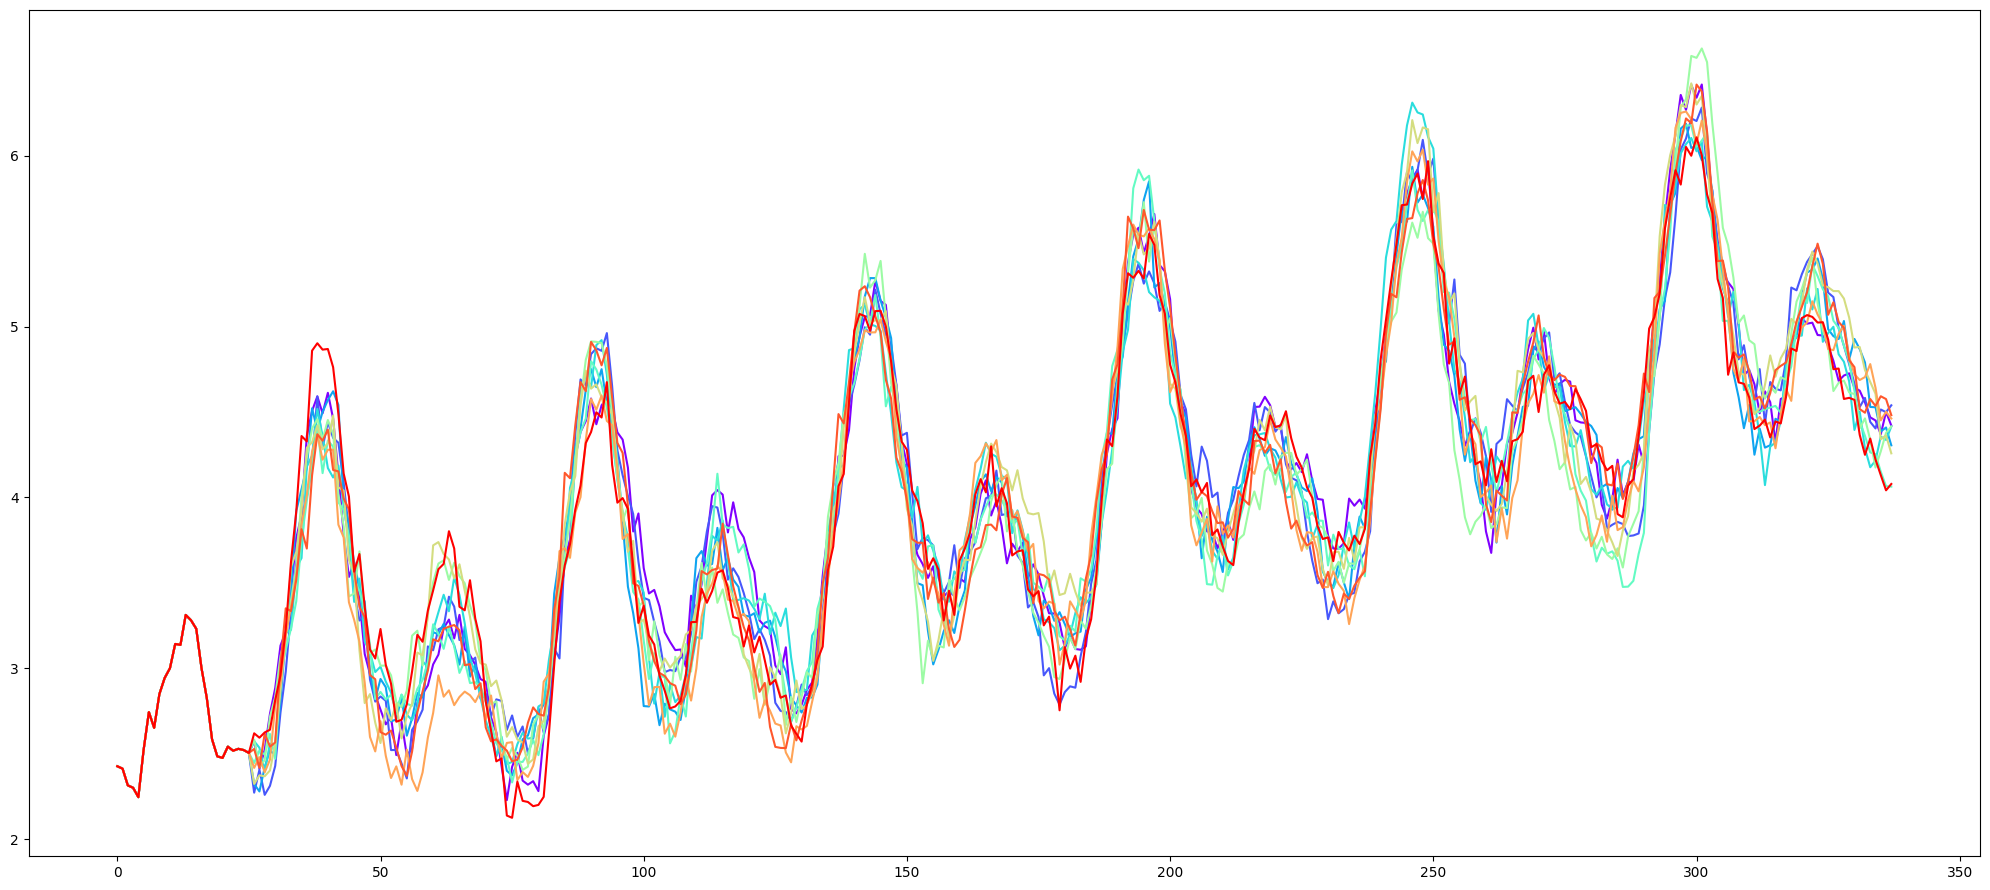

In [7]:
# Training RL
# Initialize environment
from pytagi.LSTM_KF_RL_Env import LSTM_KF_Env
train_dtl = BDLM.train_dtl
env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, \
                    ts_model=BDLM.model, step_look_back=64)
state, _ = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_lstm), var_preds_lstm = copy.deepcopy(init_var_lstm),\
                    net_test=LSTM_net, init_mu_W2b=init_mu_W2b, init_var_W2b=init_var_W2b, phi_AR=BDLM.phi_AR, Sigma_AR=BDLM.Sigma_AR,
                    phi_AA = BDLM.phi_AA, Sigma_AA_ratio = BDLM.Sigma_AA_ratio)
n_actions = env.action_space.n
n_observations = len(state['hidden_states'])

agents_RL = regime_change_detection_RLKF(trained_BDLM = BDLM, val_datetime_values = val_datetime_values,
                                         n_observations = n_observations, n_actions = n_actions)
# # Generate synthetic time series
agents_RL.generate_synthetic_ts(num_syn_ts = 200, syn_ts_len = hyperparameters['kernel']['period'] * 6)
agents_RL.save_synthetic_ts(datetime_save_path='data/synthetic_ts/RLDS_syn_datetime_200episodes.csv',
                            observation_save_path='data/synthetic_ts/RLDS_syn_observation_200episodes.csv')

[26.  1.  2. 10.  2.  3.  1.  0.  1.  1.  1.  1.  2.  1.  1.  1.  3.  1.
  1.  0.  0.  0.  0.  3.  0.  5.  0.  1.  0.  4.  2.  1.  1.  3.  0.  1.
  1.  2.  0.  0.  1.  3.  1.  3.  2.  0.  1.  1.  1.  0.  2.  1.  2.  2.
  0.  2.  2.  1.  2.  0.  1.  1.  1.  1.  2.  1.  1.  2.  0.  0.  2.  1.
  1.  1.  2.  1. 12.  0.  0.  0.  1.  0.  1.  0.  2.  1.  2.  0.  2.  1.
  0.  0.  1.  1.  1.  0.  2.  2.  1.  2.  2.  0.  0.  2.  2.  0.  2.  2.
  0.  0.  1.  0.  2.  2.  1.  1.  2.  0.  1.  1.  0.  1.  0.  0.  0.  3.
  5.  0.  2.  1.  6.  2.  2.  1.  1.  0.  2.  1.  0.  0.  2.  0.  0.  0.
  2.  1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  2.  0.  0.  0.  0.  1.  0.
  0.  5.  0.  0.  0.  2.  1.  0. 13.  1. 29.  0.  2.  1.  0.  0.  1.  0.
  1.  1.  4.  2.  1.  6.  1.  1.  8.  1.  0.  1.  0.  2.  1.  0.  1.  1.
  7.  1.]


<Figure size 640x480 with 0 Axes>

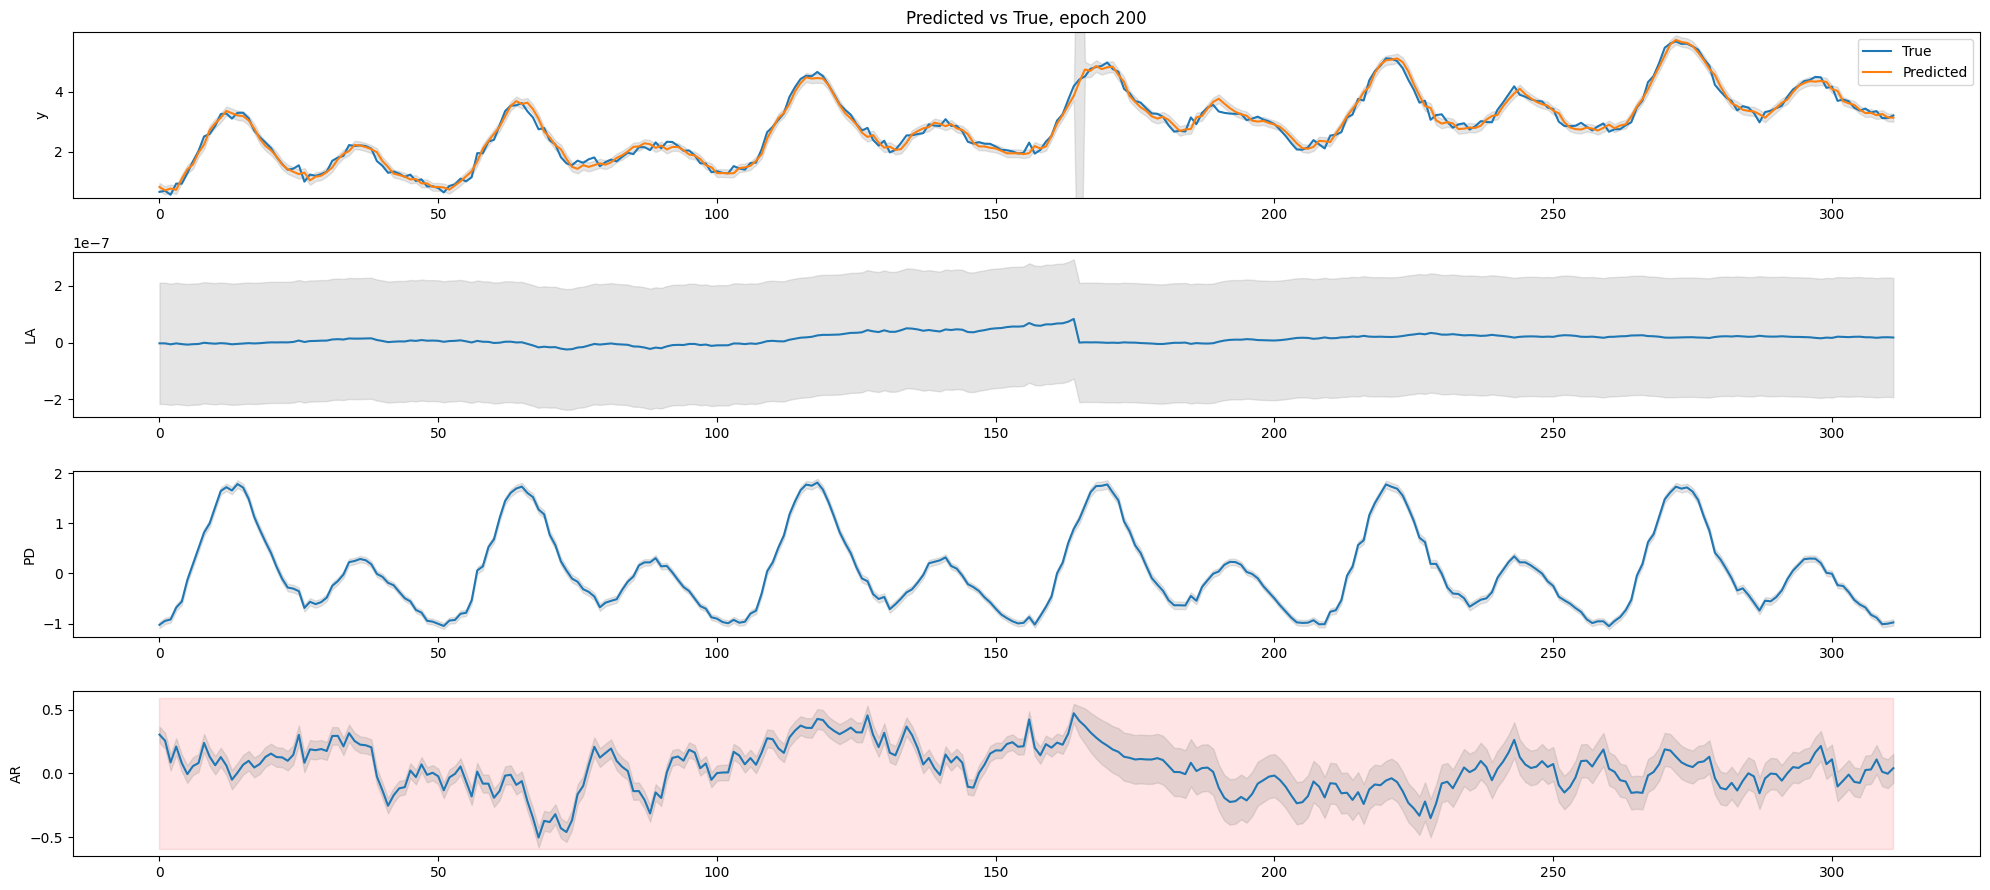

Complete


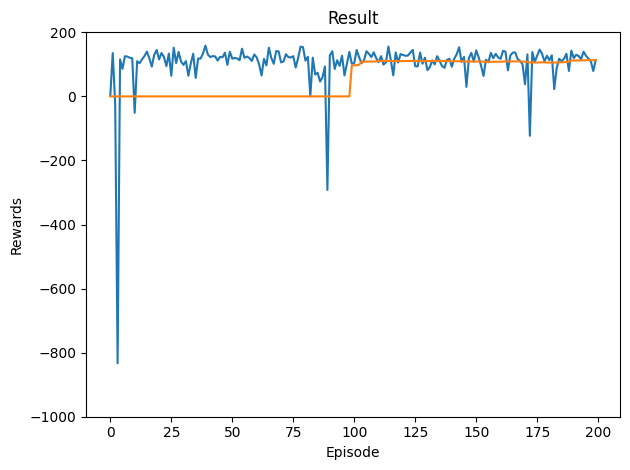

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

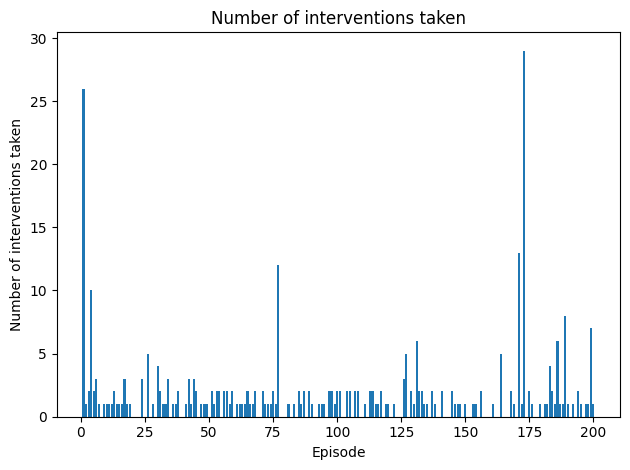

In [8]:
agents_RL.load_synthetic_ts(datetime_save_path='data/synthetic_ts/RLDS_syn_datetime_200episodes.csv',
                            observation_save_path='data/synthetic_ts/RLDS_syn_observation_200episodes.csv')
agents_RL.plot_synthetic_ts()

# Training
agents_RL.train(num_episodes = 200, step_look_back = 64, abnormal_ts_percentage = 0.5, anomaly_range = [-0.05, 0.05],
                init_z = init_z, init_Sz = init_Sz, init_mu_preds_lstm = init_mu_lstm, init_var_preds_lstm = init_var_lstm,
                batchsize = 128, TAU = 0.005, plot_samples = True, learning_curve_ylim = [-1000, 200])

In [9]:
from itertools import count
import torch
from src.RL_functions.dqn_lstm_agent import *

step_look_back = 64
env = LSTM_KF_Env(render_mode=None, data_loader=BDLM.test_dtl, \
                    ts_model=BDLM.model, step_look_back=step_look_back)

state, info = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_lstm), var_preds_lstm = copy.deepcopy(init_var_lstm),
                        net_test = LSTM_net, init_mu_W2b = init_mu_W2b, init_var_W2b = init_var_W2b, phi_AR=BDLM.phi_AR, Sigma_AR=BDLM.Sigma_AR,
                        phi_AA = BDLM.phi_AA, Sigma_AA_ratio = BDLM.Sigma_AA_ratio)

intervention_index =[]
intervention_taken = False
LA_var_stationary = BDLM.Sigma_AA_ratio *  BDLM.Sigma_AR/(1 - BDLM.phi_AA**2)
AR_std_stationary = np.sqrt(BDLM.Sigma_AR/(1 - BDLM.phi_AR**2))
if step_look_back == 64:
    seg_len = 8
RL_step_taken = 0
for t in count():
    state = torch.tensor(state['hidden_states'],\
                        dtype=torch.float32, device='cpu').unsqueeze(0)
    state = normalize_tensor_two_parts(state, 0, np.sqrt(LA_var_stationary),\
                                        0, AR_std_stationary, seg_len)
    action = agents_RL._select_action(state, greedy=True)
    action = action.item()
    # action = 0

    if RL_step_taken >= 900-64:
        state, reward, terminated, truncated, info = env.step(action, add_anomaly = True, anomaly_scale = 1.1e-2*(RL_step_taken-(900-64)))
    else:
        state, reward, terminated, truncated, info = env.step(action)

    # state, reward, terminated, truncated, info = env.step(action)

    RL_step_taken += 1

    if action == 1:
        intervention_index.append(t + step_look_back + 1)
        intervention_taken = True

    done = terminated or truncated
    if done:
        break

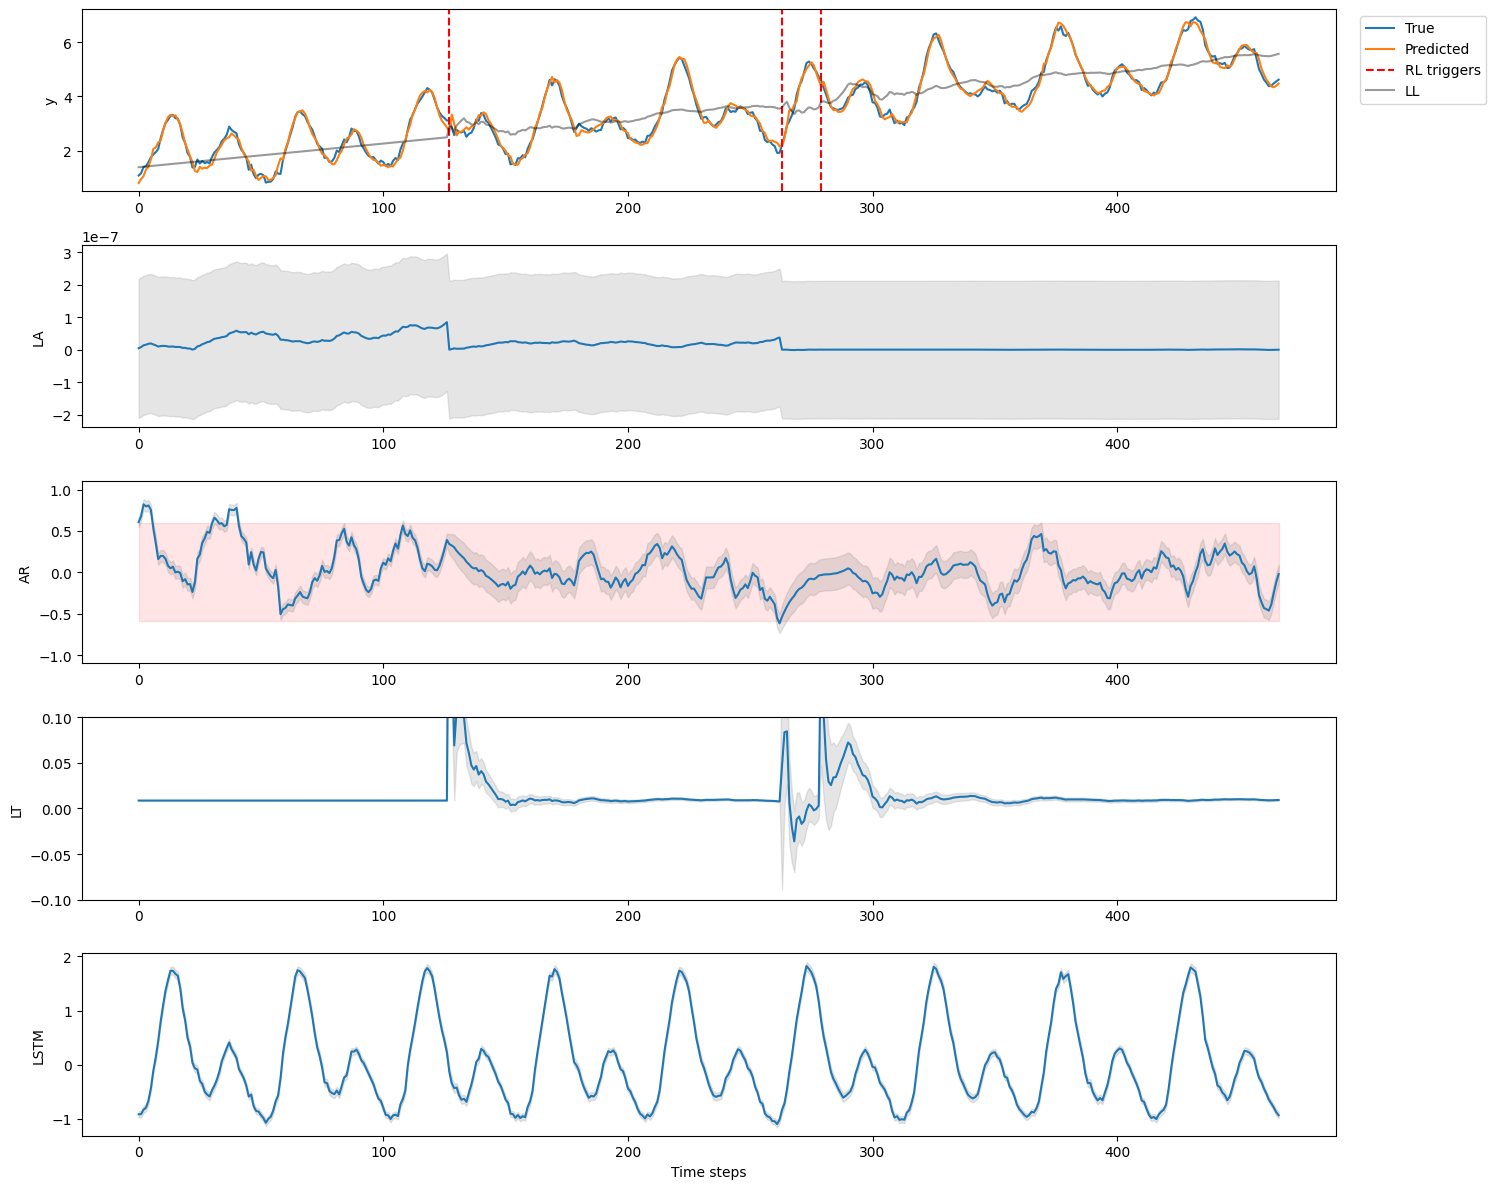

In [10]:
# Plot prediction
timesteps = np.arange(0, len(info['measurement_one_episode']), 1)
mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()
from matplotlib import gridspec
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(5, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])


ax0.plot(timesteps, info['measurement_one_episode'], label='True')
ax0.plot(timesteps, mu_prediction_one_episode , label='Predicted')
for count, i in enumerate(intervention_index):
    if count == 0:
        ax0.axvline(x=timesteps[i], color='r', linestyle='--', label='RL triggers')
    else:
        ax0.axvline(x=timesteps[i], color='r', linestyle='--')
ax0.plot(timesteps, mu_hidden_states_one_episode[:,0], color = 'k',alpha=0.4, label='LL')
# ax0.fill_between(timesteps, mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),\
#                     mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]), color='gray', alpha=0.2)
ax0.set_ylabel('y')
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.07,1))


ax1.plot(timesteps, mu_hidden_states_one_episode[:,2], label='LA')
ax1.fill_between(timesteps, mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),\
                    mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]), color='gray', alpha=0.2)
ax1.set_ylabel('LA')

ax2.fill_between(timesteps, np.zeros_like(timesteps)-3*AR_std_stationary, np.zeros_like(timesteps)+3*AR_std_stationary, color='red', alpha=0.1)
ax2.plot(timesteps, mu_hidden_states_one_episode[:,-2], label='AR')
ax2.fill_between(timesteps, mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),\
                    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]), color='gray', alpha=0.2)
ax2.set_ylabel('AR')
ax2.set_ylim(-1.1, 1.1)

ax3.plot(timesteps, mu_hidden_states_one_episode[:,1], label='LT')
ax3.fill_between(timesteps, mu_hidden_states_one_episode[:,1] - np.sqrt(var_hidden_states_one_episode[:,1,1]),\
                    mu_hidden_states_one_episode[:,1] + np.sqrt(var_hidden_states_one_episode[:,1,1]), color='gray', alpha=0.2)
ax3.set_ylabel('LT')
ax3.set_ylim(-0.1,0.1)

ax4.plot(timesteps, mu_hidden_states_one_episode[:,-1], label='LSTM')
ax4.fill_between(timesteps, mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),\
                    mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]), color='gray', alpha=0.2)
ax4.set_ylabel('LSTM')
ax4.set_xlabel('Time steps')
plt.show()

In [11]:
print(init_z)

[[ 1.38367415]
 [ 0.00868031]
 [ 0.        ]
 [ 0.47844506]
 [-0.96595032]]
